In [1]:
import string
import numbers
import numpy as np
import pandas as pd
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.optimize
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.cm as cm
from matplotlib.path import Path
import numba

import utility as util
import utility.npu

COLORS = ['r', 'b', 'g', 'y', 'm', 'c', 'orange', 'purple', 'brown', 'teal', 'pink', 'turquoise']

POINTS_1 = np.array([
    [  1  ,  2],
    [-10  ,  1],
    [  1  ,  0],
    [  2  , 10],
    [  2.5, 15],
    [  4  , 10],
    [-10  ,  5],
    [  0  , 10]
])

POINTS_2 = np.array([
    [  1, 2],
    [ -1, 1],
    [  1, 0],
    [  2, 1],
    [  2, 4],
    [  0, 3],
    [ -1, 3]
])

POINTS_3 = np.array([
    [0 , 0],
    [1 , 0],
    [3 , 1],
    [4 , 0],
    [5 ,-1],
    [7 , 0],
])

def deg_to_components(deg):
    r = np.deg2rad(deg)
    return np.array([np.cos(r), np.sin(r)])
degs = np.concatenate((
        np.full(4, 0),
        np.arange(0, 40, 10),
        np.arange(30, -260, -20),
        np.full(6, -260),
        np.arange(-280, -390, -20),
        np.full(6, -30)))

states = [ np.array([0, 0]) ]
for deg in degs:
    states.append(states[-1] + deg_to_components(deg))
POINTS_4 = np.stack(states)

## Spline fitting

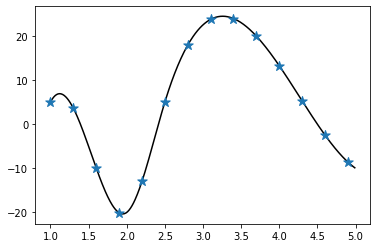

In [3]:
# scipy cubic splines are not parameterized by arc length
x = np.array([1, 1.5, 2, 2.5, 4.5, 5])  # sort data points by increasing x value
y = np.array([5, -5, -20, 5, 0, -10])
arr = np.arange(np.amin(x), np.amax(x), 0.01)
s = scipy.interpolate.CubicSpline(x, y)

fig, ax = plt.subplots(1, 1)
ax.plot(arr, s(arr), 'k-')

z = np.arange(np.amin(x), np.amax(x), 0.3)
ax.scatter(z, s(z), s=100, marker='*', zorder=10)
None

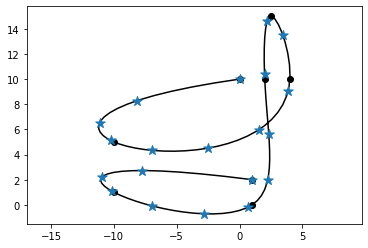

In [44]:
## Interpolating curves from points. This works if the points do not have duplicates, and there are at least 3 points.
## The spline curve is not parameterized by arc length.
## Documentation:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

plt.plot(*POINTS_1.T, 'ok')

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(POINTS_1, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

## scipy.interpolate.interp1d(x, y, kind='linear', axis=- 1, copy=True, bounds_error=None,
##                            fill_value=nan, assume_sorted=False)
## x: (N,) array_like
##    A 1-D array of real values.
## y: (...,N,...) array_like
##    A N-D array of real values. The length of y along the interpolation axis must be equal to the length of x.
## kind: str or int, optional
##       One of ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’.
## axis: int, optional
##       Specifies the axis of y along which to interpolate. Interpolation defaults to the last axis of y.

interpolator =  scipy.interpolate.interp1d(distance, POINTS_1, kind='cubic', axis=0)
alpha = np.linspace(0, 1, 100)
# curve has shape (100, 2)
curve = interpolator(alpha)
plt.plot(*curve.T, '-k')

alpha = np.linspace(0, 1, 20)
curve = interpolator(alpha)
plt.scatter(*curve.T, s=100, marker='*', zorder=10)

plt.axis("equal")
None

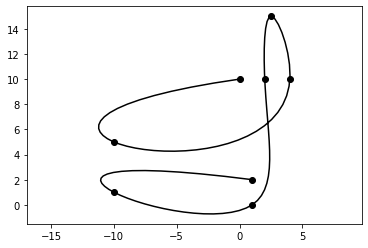

In [226]:
# scipy.interpolate.CubicSpline() is the same as scipy.interpolate.interp1d() with 'cubic' setting

plt.plot(*POINTS_1.T, 'ok')
distance = np.cumsum( np.sqrt(np.sum( np.diff(POINTS_1, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

interpolator = scipy.interpolate.CubicSpline(distance, POINTS_1, axis=0)
alpha = np.linspace(0, 1, 100)
# curve has shape (100, 2)
curve = interpolator(alpha)
plt.plot(*curve.T, '-k')

plt.axis("equal")
None

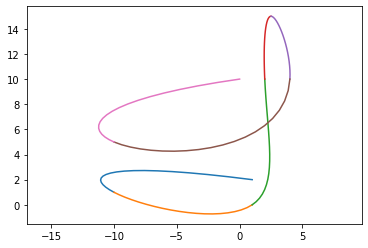

In [254]:
# manually plot the line segments of cubic spline interpolation
distance = np.cumsum( np.sqrt(np.sum( np.diff(POINTS_1, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]
interpolator = scipy.interpolate.CubicSpline(distance, POINTS_1, axis=0)

# interpolator.c coefficients of shape (4, 7, 2)
# interpolator.x the breakpoints of shape (8,)
z = interpolator.x[0:2]

for idx in range(interpolator.c.shape[1]):
    z0 = interpolator.x[idx]
    z1 = interpolator.x[idx+1]
    a_x, b_x, c_x, d_x = interpolator.c[:, idx, 0]
    a_y, b_y, c_y, d_y = interpolator.c[:, idx, 1]
    def f_x(z):
        return a_x*(z - z0)**3 + b_x*(z - z0)**2 + c_x*(z - z0) + d_x
    def f_y(z):
        return a_y*(z - z0)**3 + b_y*(z - z0)**2 + c_y*(z - z0) + d_y
    z = np.linspace(z0, z1, 20)
    plt.plot(f_x(z), f_y(z))

plt.axis("equal")
None

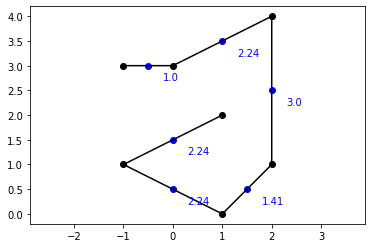

In [57]:
# Get midpoints between segments of a piecewise linear interpolated curve and the length of each linear segment
plt.plot(*POINTS_2.T, 'ok')

mpoints = POINTS_2[:-1] + np.diff(POINTS_2, axis=0) / 2
plt.plot(*mpoints.T, 'o', c='b')

distance = util.npu.consecutive_points_distances(POINTS_2)
for idx, mpoint in enumerate(mpoints):
    x, y = mpoint
    d = distance[idx].round(2)
    plt.text(x + 0.3, y - 0.3, f"{d}", color='b', zorder=10)
    
distance = util.npu.cumulative_points_distances(POINTS_2)
distance = np.insert(distance, 0, 0) / distance[-1]
interpolator =  scipy.interpolate.interp1d(distance, POINTS_2, kind='linear', axis=0)
alpha = np.linspace(0, 1, 100)
# curve has shape (100, 2)
curve = interpolator(alpha)
plt.plot(*curve.T, '-k')

plt.axis("equal")
None

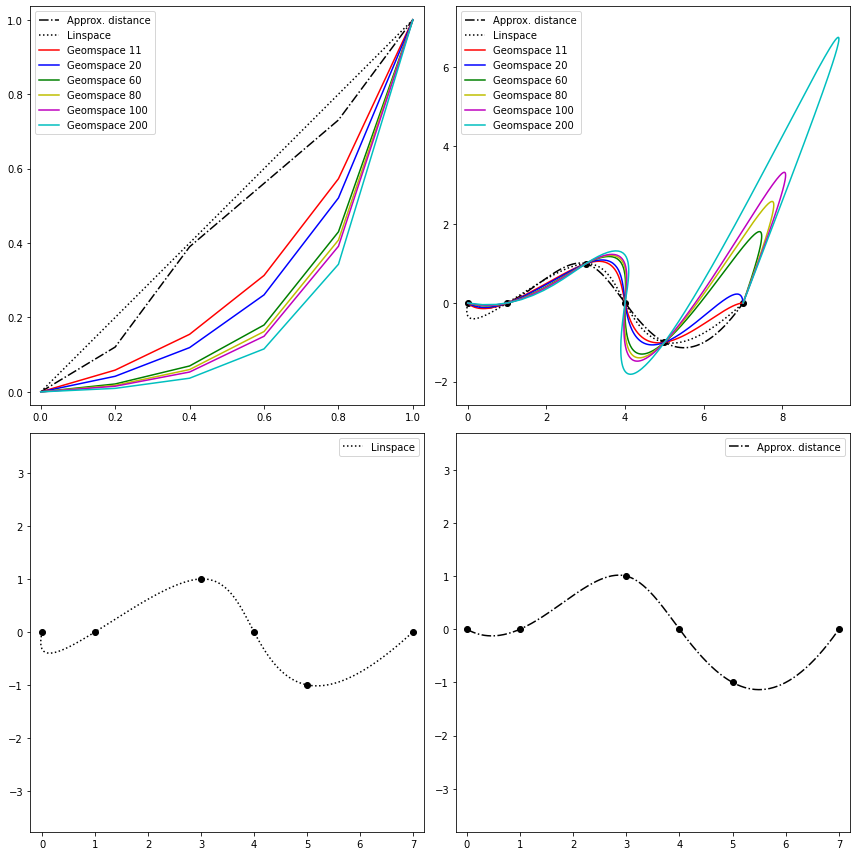

In [155]:
# Fitting a spline requires passing cumulative lengths normalized to [0, 1]
# to specify the length of each segment between consecutive interpolated points.
# An ideal cumulative lengths is done by approximating the segment lengths by
# computing the distance between consecutive points
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

points = POINTS_3
for ax in axes[1:]:
    ax.plot(*points.T, 'ok')
N = points.shape[0]
beta  = np.linspace(0, 1, N)
alpha = np.linspace(0, 1, 300)

distance = util.npu.cumulative_points_distances(points)
distance = np.insert(distance, 0, 0) / distance[-1]
interpolator =  scipy.interpolate.interp1d(distance, points, kind='cubic', axis=0)
curve = interpolator(alpha)
axes[0].plot(beta, distance, '-.k', label="Approx. distance")
axes[1].plot(*curve.T, '-.k', label="Approx. distance")
axes[3].plot(*curve.T, '-.k', label="Approx. distance")

distance = np.linspace(0, 1, N)
interpolator =  scipy.interpolate.interp1d(distance, points, kind='cubic', axis=0)
curve = interpolator(alpha)
axes[0].plot(beta, distance, ':k', label="Linspace")
axes[1].plot(*curve.T, ':k', label="Linspace")
axes[2].plot(*curve.T, ':k', label="Linspace")

Ms = [11, 20, 60, 80, 100, 200]
for idx, M in enumerate(Ms):
    distance = (np.geomspace(1, M + 1, N, endpoint=True) - 1) / M
    axes[0].plot(beta, distance, '-', c=COLORS[idx], label=f"Geomspace {M}")
    
    interpolator =  scipy.interpolate.interp1d(distance, points, kind='cubic', axis=0)
    curve = interpolator(alpha)
    axes[1].plot(*curve.T, '-', c=COLORS[idx], label=f"Geomspace {M}")
    
for ax in axes:
    ax.axis("equal")
    ax.legend()
fig.tight_layout()

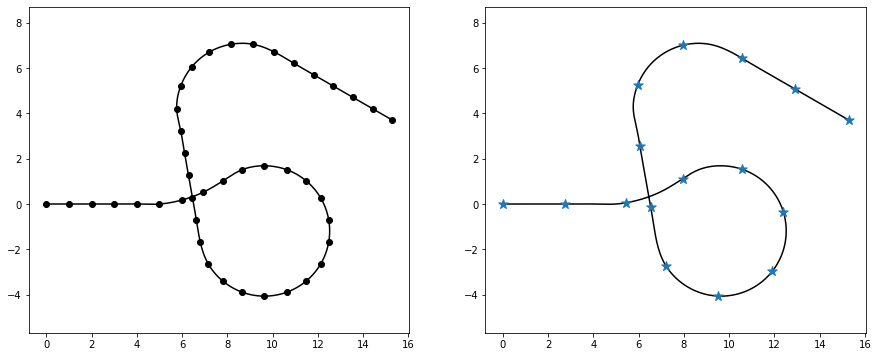

In [260]:
# When interpolated points are equally spaced apart,
# then cublic spline has segments that roughly equally the same lengths

X = POINTS_4

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(*X.T, "ko")

N = X.shape[0]
distance = np.linspace(0, 1, N)

interpolator = scipy.interpolate.CubicSpline(distance, X, axis=0)
alpha = np.linspace(0, 1, 300)
curve = interpolator(alpha)
for ax in axes:
    ax.plot(*curve.T, '-k')

alpha = np.linspace(0, 1, 16)
curve = interpolator(alpha)
axes[1].scatter(*curve.T, s=100, marker='*', zorder=10)
    
for ax in axes:
    ax.axis("equal")


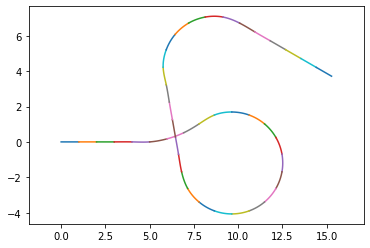

In [40]:
# manually plot the line segments of cubic spline interpolation

X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
interpolator = scipy.interpolate.CubicSpline(distance, X, axis=0)

# interpolator.c coefficients of shape (4, 7, 2)
# interpolator.x the breakpoints of shape (8,)
z = interpolator.x[0:2]

for idx in range(interpolator.c.shape[1]):
    z0 = interpolator.x[idx]
    z1 = interpolator.x[idx+1]
    a_x, b_x, c_x, d_x = interpolator.c[:, idx, 0]
    a_y, b_y, c_y, d_y = interpolator.c[:, idx, 1]
    def f_x(z):
        return a_x*(z - z0)**3 + b_x*(z - z0)**2 + c_x*(z - z0) + d_x
    def f_y(z):
        return a_y*(z - z0)**3 + b_y*(z - z0)**2 + c_y*(z - z0) + d_y
    z = np.linspace(z0, z1, 20)
    plt.plot(f_x(z), f_y(z))

plt.axis("equal")
None

(10.491777318458427, 10.475748769938406, 10.518892334960501)

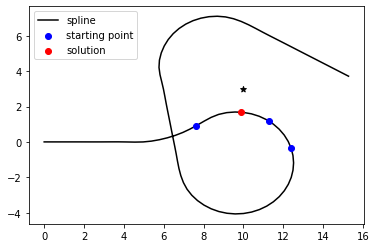

In [23]:
# Quadratic minimization to find closest point in spline to point p0 given 3 arbitrary initializations
X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
interpolator = scipy.interpolate.CubicSpline(distance, X, axis=0)
p0 = np.array([10, 3])

D = lambda s: np.sum((interpolator(s) - p0)**2)
def quadratic_min_step(s1, s2, s3):
    P = lambda s: (s - s2)*(s - s3)*D(s)/((s1 - s2)*(s1 - s3)) \
                + (s - s1)*(s - s3)*D(s)/((s2 - s1)*(s2 - s3)) \
                + (s - s1)*(s - s2)*D(s)/((s3 - s1)*(s3 - s2))
    s4 = 0.5*((s2**2 - s3**2)*D(s1) + (s3**2 - s1**2)*D(s2) + (s1**2 - s2**2)*D(s3)) \
            / ((s2 - s3)*D(s1) + (s3 - s1)*D(s2) + (s1 - s2)*D(s3))
    l = [(P(s1), s1), (P(s2), s2), (P(s3), s3), (P(s4), s4)]
    l.sort(key=lambda x: x[0], reverse=False)
    return l[0][1], l[1][1], l[2][1]

s1, s2, s3 = 8, 12, 14
plt.scatter(*interpolator([s1, s2, s3]).T, zorder=10, color='b', label="starting point")
for i in range(3):
    s1, s2, s3 = quadratic_min_step(s1, s2, s3)

distances = np.linspace(0, N, 100)
Y = interpolator(distances)
plt.plot(*Y.T, "-k", label="spline")
plt.scatter(p0[0], p0[1], color="k", marker="*")
plt.scatter(*interpolator(s1), zorder=10, color='r', label="solution")
plt.legend()
s1, s2, s3

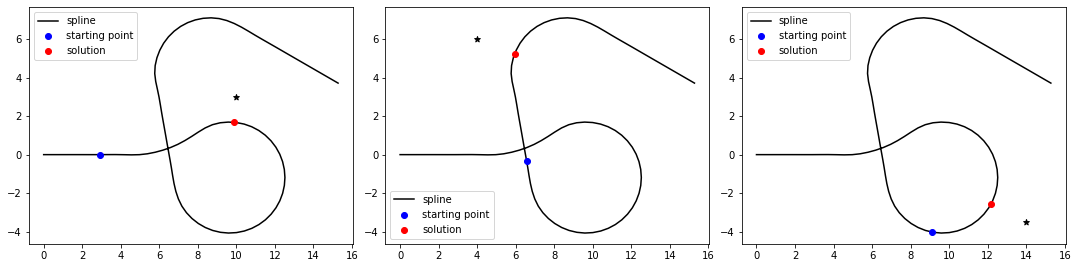

In [18]:
# Newton's method to find closest point in spline to point p0
X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
D = lambda s: np.sum((spline(s) - p0)**2)

def spline_newtons_method(s, goal):
    """ """
    while True:
        Q = spline(s)
        dQ = dspline(s)
        ddQ = ddspline(s)
        dD = 2*np.sum((Q - goal)*dQ)
        ddD = 2*np.sum(dQ**2 + (Q - goal)*ddQ)
        s_prime = s - dD/ddD
        if np.abs(s - s_prime) < 0.01:
            return s_prime
        else:
            s = s_prime

scenarios = [
    util.AttrDict(start=3, goal=np.array([10, 3])),
    util.AttrDict(start=25, goal=np.array([4, 6])),
    util.AttrDict(start=20, goal=np.array([14, -3.5]))
]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.ravel()

for ax, scenario in zip(axes, scenarios):
    ax.scatter(*spline(scenario.start), zorder=10, color='b', label="starting point")
    end = spline_newtons_method(scenario.start, scenario.goal)
    distances = np.linspace(0, N, 100)
    Y = spline(distances)
    ax.plot(*Y.T, "-k", label="spline")
    ax.scatter(scenario.goal[0], scenario.goal[1], color="k", marker="*")
    ax.scatter(*spline(end), zorder=10, color='r', label="solution")
    ax.legend()
    ax.set_aspect('equal')

fig.tight_layout()

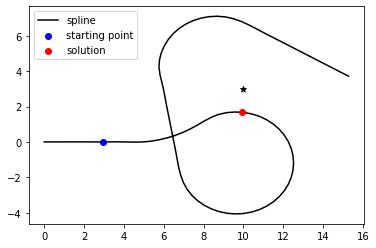

In [2]:
# Newton's method to find closest point in spline to point p0
X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
p0 = np.array([10, 3])

dspline = spline.derivative(1)
ddspline = spline.derivative(2)

D = lambda s: np.sum((spline(s) - p0)**2)
dD = lambda s: 2*np.sum((spline(s) - p0)*dspline(s))
ddD = lambda s: 2*np.sum(dspline(s)**2 + (spline(s) - p0)*ddspline(s))

def newtons_method_step(s):
    return s - dD(s)/ddD(s)

s = 3
plt.scatter(*spline(s), zorder=10, color='b', label="starting point")
for i in range(1):
    s = newtons_method_step(s)

distances = np.linspace(0, N, 100)
Y = spline(distances)
plt.plot(*Y.T, "-k", label="spline")
plt.scatter(p0[0], p0[1], color="k", marker="*")
plt.scatter(*spline(s), zorder=10, color='r', label="solution")
plt.legend()

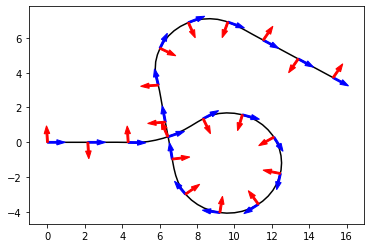

In [2]:
# Getting the tangent and normal vectors at equally spaced points of the arc-length parameterized spline.
X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)

distances = np.linspace(0, N, 20)
for X, dX, ddX in zip(spline(distances), dspline(distances), ddspline(distances)):
    # plot tangent vectors
    dX = 0.5* dX / np.linalg.norm(dX)
    plt.arrow(*X, *dX, color="b", zorder=10, width=0.1)
    # plot normal vectors
    ddX = 0.5* ddX / np.linalg.norm(ddX)
    plt.arrow(*X, *ddX, color="r", zorder=10, width=0.1)

plt.plot(*spline(np.linspace(0, N, 100)).T, "-k", label="spline")

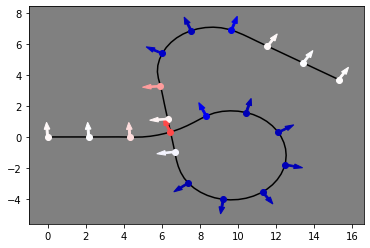

In [3]:
# Boundary normal vectors
# signed curvature for a curve Q = (x,y) of 2 dimensions is k = (x'y'' - y'x'')/(x'^2 + y'^2)^(3/2)
# more generally it is k = det(Q', Q'')/|| Q' ||^3
# https://en.wikipedia.org/wiki/Curvature

X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)

plt.plot(*spline(np.linspace(0, N, 100)).T, "-k", label="spline")

distances = np.linspace(0, N, 20)
cmap = cm.seismic
norm = clr.Normalize(vmin=-0.50, vmax=0.50, clip=True)
ks = []
np.set_printoptions(precision=3)
for X, dX, ddX in zip(spline(distances), dspline(distances), ddspline(distances)):
    # plot signed curvature
    k = (dX[0]*ddX[1] - dX[1]*ddX[0])/np.linalg.norm(dX)**3
    # print(np.round(k, 3), np.round(1/k, 3), end='; ')
    ks.append(k)
    plt.scatter(*X, color=cmap(norm(k)), zorder=10)
    # plot normal vectors
    sgn = np.sign(dX[0]*ddX[1] - dX[1]*ddX[0])
    ddX = sgn*0.5* ddX / np.linalg.norm(ddX)
    plt.arrow(*X, *ddX, color=cmap(norm(k)), zorder=10, width=0.1)
ks = np.array(ks)
plt.gca().set_facecolor("grey")

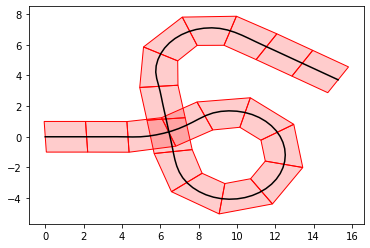

In [2]:
# covering spline with trapezoids

X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)

plt.plot(*spline(np.linspace(0, N, 100)).T, "-k", label="spline")

distances = np.linspace(0, N, 20)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    p1 = X1 + sgn1* ddX1 / np.linalg.norm(ddX1)
    p2 = X2 + sgn2* ddX2 / np.linalg.norm(ddX2)
    p3 = X2 - sgn2* ddX2 / np.linalg.norm(ddX2)
    p4 = X1 - sgn1* ddX1 / np.linalg.norm(ddX1)
    vertices = np.stack((p1, p2, p3, p4))
    patch = patches.Polygon(vertices, fill=True, fc=(1, 0, 0, 0.2), color='r')
    plt.gca().add_patch(patch)

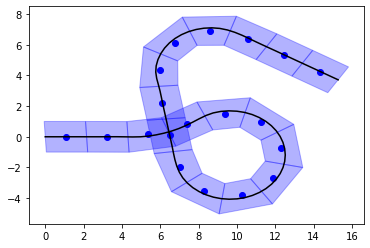

In [37]:
# covering spline with trapezoids, and use H-representation

X = POINTS_4
N = X.shape[0]
distance = np.linspace(0, N, N)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)

plt.plot(*spline(np.linspace(0, N, 100)).T, "-k", label="spline")

distances = np.linspace(0, N, 20)

# vertex_set has shape (n covers, 4, 2)
vertex_set = []
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    p1 = X1 + sgn1* ddX1 / np.linalg.norm(ddX1)
    p2 = X2 + sgn2* ddX2 / np.linalg.norm(ddX2)
    p3 = X2 - sgn2* ddX2 / np.linalg.norm(ddX2)
    p4 = X1 - sgn1* ddX1 / np.linalg.norm(ddX1)
    vertex_set.append(np.stack((p1, p2, p3, p4)))
vertex_set = np.stack(vertex_set)

for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(plt.gca(), A, b, fc='b', ec='b', alpha=0.3)
    
X = np.mean(vertex_set, axis=1)
plt.scatter(*X.T, c="b")

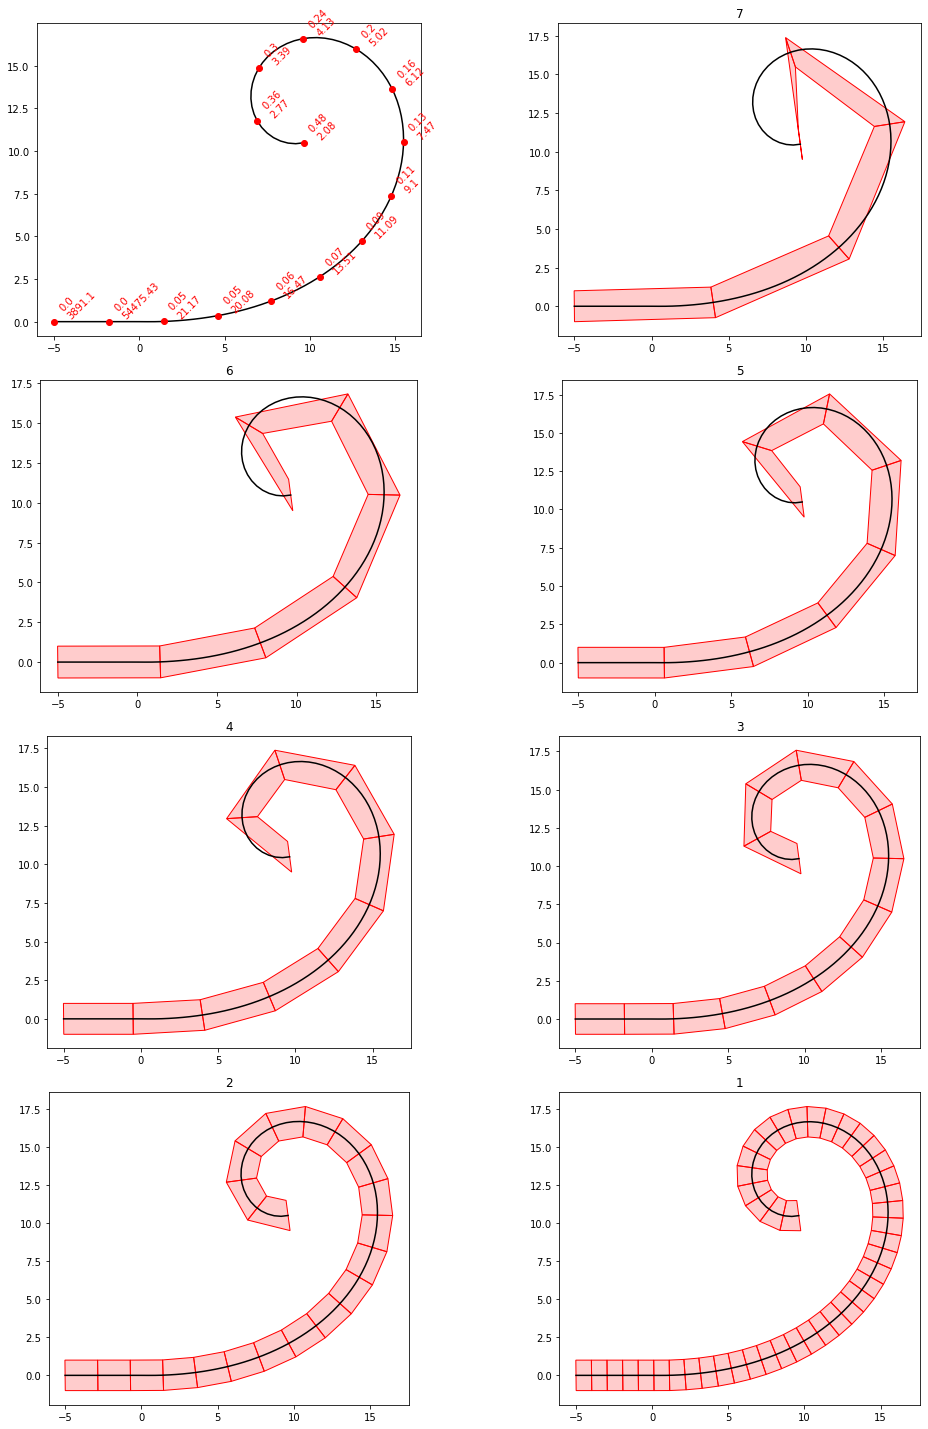

In [10]:
# What is the optimal length of covering trapezoids as a function of spline curvature?
# recall curvature = 1 / radius = \sqrt{x''^2 + y''^2} where spline is Q = (x, y)

def deg_to_components(deg):
    r = np.deg2rad(deg)
    return np.array([np.cos(r), np.sin(r)])

N = 40
x = (np.geomspace(1, 11, N) - 1) / 10
degs = x * 360
points = [ np.array([-5, 0]), np.array([-4, 0]), np.array([-3, 0]),
           np.array([-2, 0]), np.array([-1, 0]), np.array([0, 0]) ]
for deg in degs:
    points.append(points[-1] + deg_to_components(deg))
X = np.stack(points)

# distance between two consecutive points is 1 so distance of line should be (# points - 1)
L = X.shape[0] - 1
distance = np.linspace(0, L, L + 1)
spline = scipy.interpolate.CubicSpline(distance, X, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()

for ax in axes:
    ax.plot(*spline(np.linspace(0, L, 100)).T, "-k", label="spline")

distances = np.linspace(0, L, 15)
axes[0].scatter(*spline(distances).T, c="r", zorder=10)
for s in distances:
    x, y = spline(s)
    k = np.linalg.norm(ddspline(s))
    axes[0].text(x + 0.2, y + 0.2, f"{np.round(k, 2)}\n{np.round(1/k, 2)}", color="r", rotation=45, zorder=10)

for ax, width in zip(axes[1:], [7, 6, 5, 4, 3, 2, 1]):
    n = int(np.round(L / width))
    distances = np.linspace(0, L, n)
    l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
    for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
        sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
        sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
        p1 = X1 + sgn1* ddX1 / np.linalg.norm(ddX1)
        p2 = X2 + sgn2* ddX2 / np.linalg.norm(ddX2)
        p3 = X2 - sgn2* ddX2 / np.linalg.norm(ddX2)
        p4 = X1 - sgn1* ddX1 / np.linalg.norm(ddX1)
        vertices = np.stack((p1, p2, p3, p4))
        patch = patches.Polygon(vertices, fill=True, fc=(1, 0, 0, 0.2), color='r')
        ax.add_patch(patch)
    ax.set_title(str(width))

for ax in axes:
    ax.set_aspect("equal")
fig.tight_layout()
None
# k < 0.05 use 5;
# 0.05 <= k < 0.08 use 4;
# 0.08 <= k < 0.18 use 3;
# 0.18 <= k < 0.35 use 2;
# 0.35 <= k ise 1

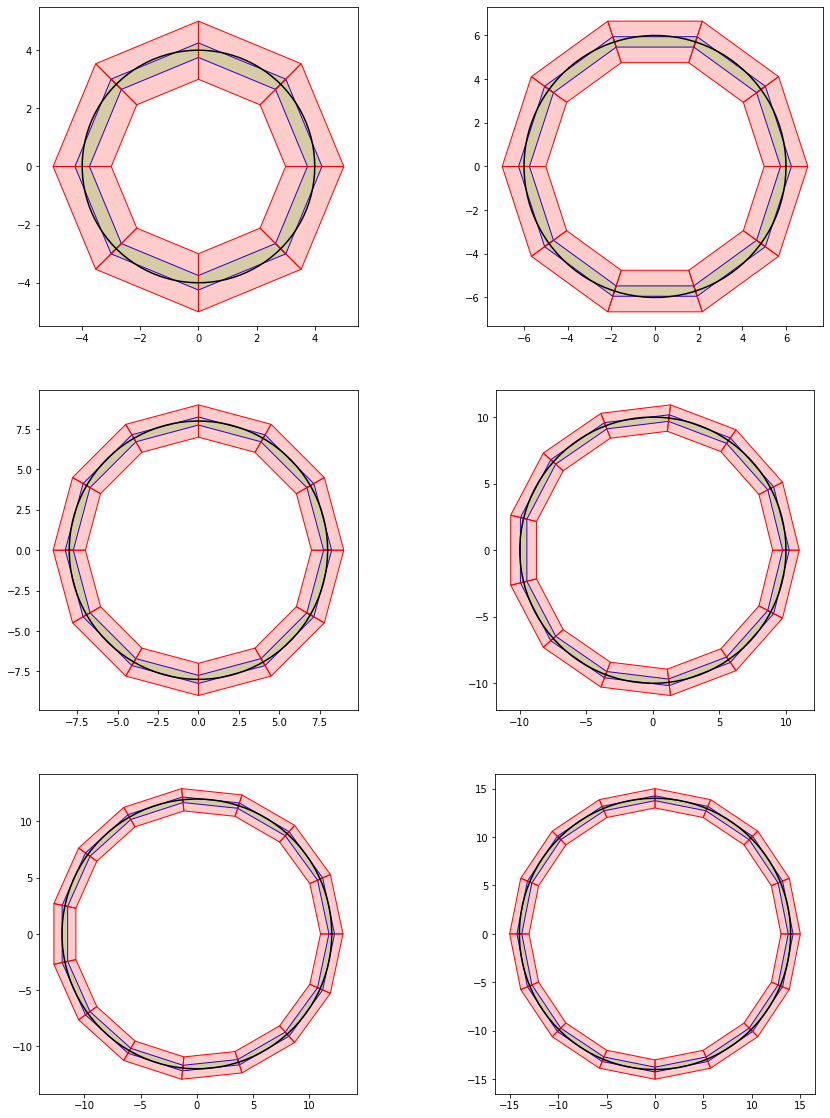

In [57]:
# figuring out how to choose length and width of cover 

def compute_segment_length(delta, k):
    return 2*np.arccos(1/(k*delta + 1))/k

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

N = 40
for ax, R in zip(axes, [4, 6, 8, 10, 12, 14]):
    r = np.linspace(0, 2*np.pi, N)
    x, y = R*np.cos(r), R*np.sin(r)
    X = np.stack((x, y), axis=1)
    L = 2*np.pi*R
    distances = np.linspace(0, L, N)
    spline = scipy.interpolate.CubicSpline(distances, X, axis=0)
    dspline = spline.derivative(1)
    ddspline = spline.derivative(2)
    
    k = np.linalg.norm(ddspline(0))
    ax.plot(*spline(np.linspace(0, L, 100)).T, "-k", label="spline")
    
    # delta is the max distance we want between spline and edge of cover 
    delta = 0.25
    # segment length required to make this happen is 2*R*np.arccos(R/(delta + R)) where R is radius
    segment_length = compute_segment_length(delta, k)
    lane_width = 1
    
    n = int(np.round(L / segment_length))
    distances = np.linspace(0, L, n)
    l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
    for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
        sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
        sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
        tangent1 = ddX1 / np.linalg.norm(ddX1)
        tangent2 = ddX2 / np.linalg.norm(ddX2)
        
        p1 = X1 + delta*sgn1*tangent1
        p2 = X2 + delta*sgn2*tangent2
        p3 = X2 - delta*sgn2*tangent2
        p4 = X1 - delta*sgn1*tangent1
        vertices = np.stack((p1, p2, p3, p4))
        patch = patches.Polygon(vertices, fill=True, fc=(0, 1, 0, 0.2), color='b')
        ax.add_patch(patch)
        
        p1 = X1 + lane_width*sgn1*tangent1
        p2 = X2 + lane_width*sgn2*tangent2
        p3 = X2 - lane_width*sgn2*tangent2
        p4 = X1 - lane_width*sgn1*tangent1
        vertices = np.stack((p1, p2, p3, p4))
        patch = patches.Polygon(vertices, fill=True, fc=(1, 0, 0, 0.2), color='r')
        ax.add_patch(patch)
    
    ax.set_aspect("equal")